In [132]:
import datetime
import json
import os
from pathlib import Path
import random
import subprocess
from osgeo import gdal, osr
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from pyproj import Transformer
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
)
from shapely.geometry import Point
from collections import defaultdict

In [2]:
def plot_image(image, factor=1, clip_range=(0, 1)):
    # Apply factor to image
    image = image * factor

    # Clip image values
    image = image.clip(clip_range[0], clip_range[1])

    # Plot the image
    plt.imshow(image)
    plt.show()

In [133]:
# will fetch the lon-lats at center of each county from the file state_county_lon_lats.csv

archive_dir = Path("ML-ARCHIVES--v01/")
scll = archive_dir / "state_county_lon_lat.csv"

df_scll = pd.read_csv(scll).drop(["lon", "lat"], axis=1)
print(df_scll.head())

  state_name county_name
0   COLORADO     LARIMER
1   COLORADO       LOGAN
2   COLORADO      MORGAN
3   COLORADO    SEDGWICK
4   COLORADO        WELD


In [134]:
county_dir = Path("COUNTY-BOUNDING-POLYGONS/")
if not county_dir.exists():
    county_dir.makedirs(exist_ok=True)
county_file = "cb_2022_us_county_20m.dbf"
county_path = county_dir / county_file

# Load county boundary data from Shapefile
counties = gpd.read_file(county_path)

In [5]:
def create_lon_lat_seqs(df_scll, counties, count):
    df_scll['STATE_NAME'] = df_scll['state_name'].apply(lambda x: x.title())
    df_scll['NAME'] = df_scll['county_name'].apply(lambda x: x.title())
    # df_scll.index.difference(counties.index)
    broken_counties = [('Illinois', 'De Kalb'),
                ('Illinois',      'La Salle'),
                ('Illinois',     'Mcdonough'),
                ('Illinois',       'Mchenry'),
                ('Illinois',        'Mclean'),
                ('Illinois',      'St Clair'),
                ( 'Indiana',       'De Kalb'),
                ( 'Indiana',      'La Porte'),
                ( 'Indiana',      'Lagrange'),
                (    'Iowa',       'O Brien'),
                (  'Kansas',     'Mcpherson'),
                ('Missouri',    'St Charles'),
                ('Missouri',      'St Louis'),
                ('Missouri', 'Ste Genevieve')]
    fixed_counties = [
        ('Illinois',          'DeKalb',   'DeKalb'),
                ('Illinois',      'Salle', ""),
                ('Illinois',     'Mcdonough', ""),
                ('Illinois',       'Mchenry', ""),
                ('Illinois',        'Mclean', ""),
                ('Illinois',      'St. Clair', ""),
                ( 'Indiana',       'DeKalb', ""),
                ( 'Indiana',      'LaPorte', ""),
                ( 'Indiana',      'Lagrange', ""),
                (    'Iowa',       'Brien', ""),
                (  'Kansas',     'Mcpherson', ""),
                ('Missouri',    'St. Charles', ""),
                ('Missouri',      'St. Louis', ""),
                ('Missouri', 'Ste. Genevieve', "")]
    for (br_state, br_county), (state, county, new_county) in zip(broken_counties, fixed_counties):
        
        sery = counties[(counties.STATE_NAME == state) & (counties.NAME.str.contains(county, case=False))][["STATE_NAME", "NAME"]]
        df_scll.loc[(df_scll.STATE_NAME == br_state) & (df_scll.NAME == br_county), ["STATE_NAME", "NAME"]] = [sery["STATE_NAME"].iloc[0], sery["NAME"].iloc[0]]
        if len(sery) == 0:
            print(county, sery)
    df_scll = df_scll.set_index(["STATE_NAME", "NAME"])
    counties = counties.set_index(["STATE_NAME", "NAME"])
    j_counties = counties.join(df_scll, on=["STATE_NAME", "NAME"], how='inner')
    assert len(df_scll.index.difference(counties.index)) == 0
    j_counties["points"] = j_counties.sample_points(size=count)
    samples = j_counties["points"].to_dict()
    seq_lat_lon = defaultdict(lambda: defaultdict(list))
    for (state, county), points in samples.items():
        seq_lat_lon[state][county] =  [ (p.x, p.y) for p in points.geoms ]
    return seq_lat_lon, j_counties


print(datetime.datetime.now())
seq_lat_lon, j_counties = create_lon_lat_seqs(df_scll, counties, 5000)
print(datetime.datetime.now())


# <span style=color:blue>Save dict as json  </span>

out_file = archive_dir / "state_county__seq_of_lon_lats.json"

with out_file.open("w") as fp:
    json.dump(seq_lat_lon, fp)



2023-06-05 16:37:39.774941
2023-06-05 16:39:17.797292


In [82]:
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import geopandas
import json

countries = gpd.GeoDataFrame(geometry=[j_counties.unary_union], crs=j_counties.crs)#.plot(alpha=0.5, edgecolor="k")

m = Map(center=(52.3,8.0), zoom = 3, basemap= basemaps.Esri.WorldTopoMap)

geo_data = GeoData(geo_dataframe = countries,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

m.add_layer(geo_data)
# m.add_layer(gpd.GeoDataFrame(geometry=[j_counties.unary_union.envelope], crs=j_counties.crs))
# m.add_control(LayersControl())

m

Map(center=[52.3, 8.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

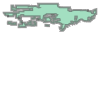

In [92]:
gpd.GeoDataFrame(geometry=[j_counties.unary_union], crs=j_counties.crs)

In [93]:
from shapely.ops import unary_union
boundary = gpd.GeoSeries(unary_union(j_counties.unary_union))

In [95]:
j_counties.unary_union.bounds

(-106.190554078709, 35.995812, -80.518893, 43.500885)

In [6]:
def make_grid(polygon, edge_size):
    """
    polygon : shapely.geometry
    edge_size : length of the grid cell
    """
    from itertools import product
    import numpy as np
    import geopandas as gpd
    
    bounds = polygon.bounds
    x_coords = np.arange(bounds[0] + edge_size/2, bounds[2], edge_size)
    y_coords = np.arange(bounds[1] + edge_size/2, bounds[3], edge_size)
    combinations = np.array(list(product(x_coords, y_coords)))
    squares = gpd.points_from_xy(combinations[:, 0], combinations[:, 1]).buffer(edge_size / 2, cap_style=3)
    return gpd.GeoSeries(squares[squares.intersects(polygon)])


In [162]:
grid = make_grid(j_counties.points.unary_union, 0.2)
countries = gpd.GeoDataFrame(geometry=grid, crs=j_counties.crs)#.plot(alpha=0.5, edgecolor="k")

m = Map(center=(52.3,8.0), zoom = 3, basemap= basemaps.Esri.WorldTopoMap)

geo_data = GeoData(geo_dataframe = countries,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

m.add_layer(geo_data)
m

Map(center=[52.3, 8.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [7]:

#!/usr/bin/env python
# coding: utf-8

# ## <span style=color:blue>This notebook builds the function soy_is_here(year,lat,lon), which produces "True" if the 100m x 100m area around lon-lat was a soybean field in the given year.  (At least, according to the data of USDA NASS.)  </span>
#
# ## <span style=color:blue>Then we import the dictionary with the lon-lat sequences for each county, and for each year find the first 20 that are in soybean fields, and right

# <span style=color:blue>First step is to create a function that tests, given a year-lon-lat triple, whether there was a soy field at lat-lon during the given year.  This is based on checking files downloaded from https://www.nass.usda.gov/Research_and_Science/Cropland/Release/index.php.  To understand the meaning of the pixel values, please see https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/meta.php and the files in there, e.g., https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_ia22.htm.  Among other things, you will see that the value of '5' corresponds to soybean fields </span>

# first, examining the structure of the files I downloaded

dir_main = Path("CROPSCAPE/DATA-DOWNLOADS/")
dir_main.mkdir(parents=True, exist_ok=True)


# following the structure of the directory name and file from downloaded zip files, which are organized by year
def pathname_for_year(year):
    last_dir_name = f"{str(year)}_30m_cdls/"
    file_name = f"{str(year)}_30m_cdls.tif"
    return dir_main / last_dir_name / file_name

def dataset_for_year(year):
    dataset = rasterio.open(str(pathname_for_year(year)))
    return dataset

# test
print(pathname_for_year(2022))
# <span style=color:blue>Now we inspect structure of the tif files.     </span>
#
# #### <span style=color:blue>Note that the Coordinate Reference System (CRS) is EPSG: 5070 rather than EPSG:4326 (also basically equivalent to WGS84), which is the one we are often using.  BTW, the unit of measure for EPSG:5070 is 1 meter, and so the pixels in these tif files are approximately 30m x 30m.  (See https://epsg.io/5070-1252) </span>


def pull_useful_gdal(dataset):
    useful = {}

    # Get raster band count
    useful["band_count"] = dataset.RasterCount

    # Get size
    useful["size"] = [dataset.RasterXSize, dataset.RasterYSize]

    # Get corner coordinates
    geotransform = dataset.GetGeoTransform()
    useful["proj:transform"] = geotransform
    x_size = dataset.RasterXSize
    y_size = dataset.RasterYSize

    corners = {
        "upperLeft": [geotransform[0], geotransform[3]],
        "lowerLeft": [geotransform[0], geotransform[3] + geotransform[5] * y_size],
        "upperRight": [geotransform[0] + geotransform[1] * x_size, geotransform[3]],
        "lowerRight": [
            geotransform[0] + geotransform[1] * x_size,
            geotransform[3] + geotransform[5] * y_size,
        ],
    }

    # Compute center coordinates
    corners["center"] = [
        (corners["upperLeft"][0] + corners["lowerRight"][0]) / 2,
        (corners["upperLeft"][1] + corners["lowerRight"][1]) / 2,
    ]
    useful["cornerCoordinates"] = corners

    # Define the source and target spatial references
    src_srs = osr.SpatialReference()
    src_srs.ImportFromWkt(dataset.GetProjection())
    print("Dataset project", dataset.GetProjection())

    tgt_srs = osr.SpatialReference()
    tgt_srs.ImportFromEPSG(4326)  # 4326  # WGS84 #  , 8826

    # Set up a coordinate transformation
    transform = osr.CoordinateTransformation(src_srs, tgt_srs)

    # Get corner coordinates and reproject them
    corners_projected = {}
    for name, coords in [
        ("upperLeft", (0, 0)),
        ("lowerLeft", (0, dataset.RasterYSize)),
        ("upperRight", (dataset.RasterXSize, 0)),
        ("lowerRight", (dataset.RasterXSize, dataset.RasterYSize)),
    ]:
        x, y = gdal.ApplyGeoTransform(geotransform, *coords)
        lon, lat, _ = transform.TransformPoint(x, y)
        corners_projected[name] = [lon, lat]
    useful["cornerCoordinatesProj"] = corners_projected

    # Get bounding box
    # bbox = {
    #     'west_longitude': min(corners_projected['upperLeft'][0], corners_projected['lowerLeft'][0], corners_projected['upperRight'][0], corners_projected['lowerRight'][0]),
    #     'north_latitude': max(corners_projected['upperLeft'][1], corners_projected['lowerLeft'][1], corners_projected['upperRight'][1], corners_projected['lowerRight'][1]),
    #     'east_longitude': max(corners_projected['upperLeft'][0], corners_projected['lowerLeft'][0], corners_projected['upperRight'][0], corners_projected['lowerRight'][0]),
    #     'south_latitude': min(corners_projected['upperLeft'][1], corners_projected['lowerLeft'][1], corners_projected['upperRight'][1], corners_projected['lowerRight'][1])
    # }
    bbox = {
        "west_longitude": corners_projected["upperLeft"][0],
        "north_latitude": corners_projected["upperLeft"][1],
        "east_longitude": corners_projected["lowerRight"][0],
        "south_latitude": corners_projected["lowerRight"][1],
    }
    useful["bbox"] = bbox
    bbox = {
        "west_longitude": corners["upperLeft"][0],
        "north_latitude": corners["upperLeft"][1],
        "east_longitude": corners["lowerRight"][0],
        "south_latitude": corners["lowerRight"][1],
    }
    useful["bbox_noproj"] = bbox

    # Get EPSG code
    useful["espgEncoding"] = int(src_srs.GetAuthorityCode(None))

    return useful


def pull_useful(
    ginfo,
):  # should give as input the result.stdout from calling gdalinfo -json
    useful = {}
    useful["band_count"] = len(ginfo["bands"])
    useful["cornerCoordinates"] = ginfo["cornerCoordinates"]
    useful["proj:transform"] = ginfo["stac"]["proj:transform"]
    useful["size"] = ginfo["size"]
    useful["bbox"] = ginfo["stac"]["proj:projjson"]["bbox"]
    useful["espgEncoding"] = ginfo["stac"]["proj:epsg"]
    return useful


path_to_file = pathname_for_year(2008)
# path_to_file = pathname_for_year(2022)
# dataset = gdal.Open(str(path_to_file))
# useful_gdal = pull_useful_gdal(dataset)
gdalInfoReq = " ".join(["gdalinfo", "-json", str(path_to_file)])

result = subprocess.run([gdalInfoReq], shell=True, capture_output=True, text=True)

print()


print(result.stderr)
gdalInfo = json.loads(result.stdout)

useful = pull_useful(gdalInfo)
with open("gdal_process.json", "w") as outfile:
    json.dump(useful, outfile, indent=2, sort_keys=True)
# with open("gdal_lib.json", "w") as outfile:
    # json.dump(useful_gdal, outfile, indent=2, sort_keys=True)
# exit()


# <span style=color:blue>Function to transform from EPSG:4326 to EPSG:5070.  The rasterio-based function we use below will take coordinates in EPSG:5010, since the tif files we are using here are in EPSG:5010.     </span>

transformer = Transformer.from_crs("EPSG:4326", "EPSG:5070")


def from_4326_to_5070(lon, lat):
    # I'm not sure why the role positions of lon-lat are different on input and output
    # but that is what my numerous small test runs showed to me
    new_lon, new_lat = transformer.transform(lat, lon)
    return new_lon, new_lat


# test on coordinates from central Iowa
# old_lon = -92.8
# old_lat = 42.7
# print(from_4326_to_5070(old_lon, old_lat))
# (you can check this at https://epsg.io/transform)
# <span style=color:blue>Function that fetches a 3x3 square of pixel values from the given tif file.  The pixels in the tif file correspond to  30m x 30m, so we are looking at a rouhgly 100m x 100m area that is all or mostly soybean field </span>
#
# <span style=color:blue>Note that in 2008 the target area was planted mainly with maize, but in 2022 it was planted with soybeans</span>


# expects lon-lat to be in EPSG:4326.
# These are converted to EPSG:5070 inside the function
def get_coordinate_pixels(dataset, lon, lat):
    lon_new, lat_new = from_4326_to_5070(lon, lat)

    py, px = dataset.index(lon_new, lat_new)

    # create 3px x 3px window centered on the lon-lat
    window = rasterio.windows.Window(px - 1, py - 1, 3, 3)
    clip = dataset.read(window=window)
    return clip


# test
# old_lon = -92.8
# old_lat = 42.7
# path_to_file = pathname_for_year(2008)
# print(get_coordinate_pixels(path_to_file, old_lon, old_lat))
# print()
# path_to_file = pathname_for_year(2022)
# print(get_coordinate_pixels(path_to_file, old_lon, old_lat))
# <span style=color:blue>Also, a function that that tests whether all 9 spots in the 3x3 square have a given value.  (We are interested in "5", which is soy beans.)</span>


# land_use_val should be an integer; see, e.g.,
#     https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_ia22.htm
#     for mapping from values to meanings
def usage_is_here(dataset, lon, lat, land_use_val):
    arr = get_coordinate_pixels(dataset, lon, lat)
    out = True
    for i in range(0, 3):
        for j in range(0, 3):
            out = out & (arr[0][i][j] == land_use_val)
    return out


def soy_is_here(dataset, lon, lat):
    return usage_is_here(dataset, lon, lat, 5) # 1 is corn, 5 is soy

def corn_is_here(dataset, lon, lat):
    return usage_is_here(dataset, lon, lat, 1) # 1 is corn, 5 is soy

# old_lon = -92.8
# old_lat = 42.7
# print(corn_is_here(2008, old_lon, old_lat))
# print(corn_is_here(2022, old_lon, old_lat))
# ### <span style=color:blue>Importing the dictionary with lon-lat sequences.  Also setting a second dict that will hold lists lon-lats that are in soybean fields.</span>

# <span style=color:blue>Function that scans through one list of lon-lats and finds first set that are in soybean fields</span>


def gen_corn_lon_lats(dataset, year, state, county, count):
    points = seq_lat_lon[state][county]
    i = 0
    out_list = []
    for ll in points:
        if corn_is_here(dataset, ll[0], ll[1]):
            out_list += [ll]
            i += 1
        if i == 20:
            return out_list, []
    print(
        f"\nFor {str(year)}, {state}, {county}: \nFailed to find {str(count)} lon-lats that were in corn fields. Found only {str(i)}.\n"
    )
    short_fall_record = [year, state, county, i]
    return out_list, short_fall_record


# corn_lat_lons, short = gen_corn_lon_lats(dataset_for_year(2008), 2008, "ILLINOIS", "MASSAC", 20)
# print(corn_lat_lons)
# print(short)
# print()
# list, short = gen_soy_lon_lats(2008, "MISSOURI", "DALLAS", 20)
# print(list)
# print(short)
# <span style=color:blue>Function that generates a fixed number of lon-lats in soybean fields for each year and each county. This took quite a while to run completely -- about 4 hours.    </span>

working_dir = Path("OUTPUTS/OUTPUT-v01/")
working_dir.mkdir(parents=True, exist_ok=True)
dict1_file = working_dir / "year_state_county_corn_seq.json"
short_list = working_dir / "year_state_county_shortfalls.json"


def gen_all_corn_lists(corn_lat_lons, count):
    dict1 = {}
    for year in range(2008, 2023):
        dict1[year] = {}
        for key in corn_lat_lons.keys():
            dict1[year][key] = {}
    print(dict1.keys())
    print(dict1[2013].keys())

    shortfall_list = []

    i = 0
    for year in dict1.keys():
        dataset = dataset_for_year(year)
        for state in corn_lat_lons.keys():
            for county in corn_lat_lons[state].keys():
                points, short = gen_corn_lon_lats(dataset, year, state, county, count)
                dict1[year][state][county] = points
                if short != []:
                    shortfall_list += [short]

                i += 1
                if i % 20 == 0:
                    print(
                        f"Have generated corn lon-lat lists for {str(i)} year-county pairs"
                    )
                if i % 50 == 0:
                    with dict1_file.open("w") as fp:
                        json.dump(dict1, fp)
                    with short_list.open("w") as fp:
                        json.dump(shortfall_list, fp)

    return dict1, shortfall_list


print(datetime.datetime.now())
dict1, short = gen_all_corn_lists(seq_lat_lon, 20)
print(datetime.datetime.now())
# <span style=color:blue>Save the dict1 and also the shortfalls    </span>

dict1_file = archive_dir / "year_state_county_corn_seq.json"
short_list = archive_dir / "year_state_county_shortfalls.json"

with dict1_file.open("w") as fp:
    json.dump(dict1, fp)
with short_list.open("w") as fp:
    json.dump(short, fp)
# <span style=color:blue>Collecting year-state-county with zero hits </span>

zero_falls = []

for l in short:
    if l[3] == 0:
        zero_falls += [[l]]

print(len(zero_falls))

print(json.dumps(zero_falls, indent=4))

zero_file = archive_dir / "year_state_county_corn_zero_falls.json"
with zero_file.open("w") as fp:
    json.dump(zero_falls, fp)
# <span style=color:blue>Checking if any year-state-county in zero_falls had a positive yield in year_state_county_yield table</span>

yscy_file = archive_dir / "year_state_county_yield.csv"

df_yscy = pd.read_csv(yscy_file)
print("Top of df_yscy")
print(df_yscy.head())

zero_with_yield = []
for l in zero_falls:
    year = l[0][0]
    state = l[0][1]
    county = l[0][2]
    rows = df_yscy[
        (df_yscy["year"] == year)
        & (df_yscy["state_name"] == state)
        & (df_yscy["county_name"] == county)
    ]
    if len(rows) > 0:
        y = rows["yield"].iloc[0]
        zero_with_yield += [
            {"year": year, "state_name": state, "county_name": county, "yield": y}
        ]

print("\nLength of zero_with_yield is: ", len(zero_with_yield))
print("\nListing of zero_with_yield")
df_zwy = pd.DataFrame(zero_with_yield)
print(df_zwy.head(30))

zero_with_yield = archive_dir / "year_state_county_soy_zero_with_yield.csv"
df_zwy.to_csv(zero_with_yield, index=False)
# <span style=color:blue>For this exercise, we will drop these year-state-county triples from consideration.  A more thorough approach would be to focus on these year-state-county pairs (and perhaps the other ones with < 20 lon-lats), and randomly generate more lon-lats within the county until at least a few are found inside soybean fields.  (On the one hand, there have to be some if there was a yield ... however, CropScape is not perfect and may not have identified them accurately.)</span>


CROPSCAPE/DATA-DOWNLOADS/2022_30m_cdls/2022_30m_cdls.tif


2023-06-05 16:44:33.779082
dict_keys([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])
dict_keys(['Illinois', 'Iowa', 'Indiana', 'Kansas', 'Nebraska', 'Ohio', 'Missouri', 'Colorado'])
Have generated corn lon-lat lists for 20 year-county pairs
Have generated corn lon-lat lists for 40 year-county pairs
Have generated corn lon-lat lists for 60 year-county pairs
Have generated corn lon-lat lists for 80 year-county pairs
Have generated corn lon-lat lists for 100 year-county pairs
Have generated corn lon-lat lists for 120 year-county pairs
Have generated corn lon-lat lists for 140 year-county pairs
Have generated corn lon-lat lists for 160 year-county pairs
Have generated corn lon-lat lists for 180 year-county pairs
Have generated corn lon-lat lists for 200 year-county pairs
Have generated corn lon-lat lists for 220 year-county pairs
Have generated corn lon-lat lists for 240 year-county pairs

In [136]:
%env SENTINEL_CLIENT_ID=0d67f2dd-b15f-4a0d-a504-143db1f4b0f7
%env SENTINEL_CLIENT_SECRET=!{nz6Re26F{>uQ2RP;h/eDuR|V%;7]hGB27.xa#W

env: SENTINEL_CLIENT_ID=0d67f2dd-b15f-4a0d-a504-143db1f4b0f7
env: SENTINEL_CLIENT_SECRET=!{nz6Re26F{>uQ2RP;h/eDuR|V%;7]hGB27.xa#W


In [137]:

#!/usr/bin/env python
# coding: utf-8

# ## <span style=color:blue>In this notebook, we illustrate how to get the NDVI value for a single cell of size roughly 100m x 100m.  This will give you the basic machinery needed to gather sequences of NDVI values that can be incorporated into your ML pipelines   </span>

# ### <span style=color:blue>First, we create function that retrieves the NVDI for a given year, week, and 100m x 100m cell centered at some lon-lat   </span>

# <span style=color:blue>To get started with accessing SentinelHub using Python, I found the site https://sentinelhub-py.readthedocs.io/en/latest/index.html to be helpful.  In particular, you can find and download the SentinelHub-py github repository at https://github.com/sentinel-hub/sentinelhub-py, and then work through some of the Examples.</span>
#
# <span style=color:blue>First, we set up access to SentinelHub</span>

# To access SentinelHub you need a client_id and client_secret.
# To get your own access to SentinelHub, go
#    to https://docs.sentinel-hub.com/api/latest/api/overview/authentication/.
#    From there you can get a user name and password for a free 30-day trial.
#    Once you sign in, find you way to
#    https://apps.sentinel-hub.com/dashboard/, and from the
#    "User Settings" area you can create an OAuth client -- this will give you
#    a Client_ID and a Client_Secret.  (I had to create a couple of these in order
#    to get one that worked.  Also, they do expire after a while...)
# I put my client_ID and client_secret into some environment variables

SENTINEL_CLIENT_ID = os.getenv("SENTINEL_CLIENT_ID")
SENTINEL_CLIENT_SECRET = os.environ.get("SENTINEL_CLIENT_SECRET")
# <span style=color:blue>Now create a client for accessing SentinelHub     </span>

config = SHConfig()

# using third client id and secret, from 2023-05-26
config.sh_client_id = SENTINEL_CLIENT_ID
config.sh_client_secret = SENTINEL_CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print(
        "Warning! To use Process API, please provide the credentials (OAuth client ID and client secret)."
    )
else:
    print("Successfully set up SentinelHub client")
# <span style=color:blue> Not sure why sentinelhub examples include this next cell, but I will blindly imitate them   </span>


# <span style=color:blue>Importing useful things from SentinelHub  </span>

# The following is not a package. It is a file utils.py which should be in the same
#     folder as this notebook.
# As a slight variation, I have cloned the sentinelhub-py repo into my local github,
#     and grab utils.py from there
# ### <span style=color:blue>As a small warm-up exercise, to help you get familiar with accessing data from SentinalHub, here is an example of pulling some RGB data and viewing it     </span>
#
# <span style=color:blue> First, identifying a couple of bounding boxes to work with. Note that the second example is focusing on a single cell with size about 100m x 100m. </span>

# convenient site for finding lat/long coordinates:
#     http://bboxfinder.com/#0.000000,0.000000,0.000000,0.000000

# Bounding box containing the 7 soybean states of interest is as follows:
# [-104.370117,35.782171,-79.628906,48.048710]
# However, this is too big of a region to request in one call to SentinelHub

# Bounding box for about 1/8 of Iowa
# [-96.481934,42.520700,-95.075684,43.516689]


Successfully set up SentinelHub client


In [10]:
j_counties.set_geometry("points")

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID   
STATE_NAME NAME                                                        
Illinois   Massac       17      127  01784730  0500000US17127  17127  \
           Kendall      17      093  00424248  0500000US17093  17093   
Iowa       Iowa         19      095  00465236  0500000US19095  19095   
Indiana    Greene       18      055  00451676  0500000US18055  18055   
           Miami        18      103  00450373  0500000US18103  18103   
...                    ...      ...       ...             ...    ...   
Iowa       Dubuque      19      061  00465219  0500000US19061  19061   
Ohio       Geauga       39      055  01074040  0500000US39055  39055   
           Clark        39      023  01074024  0500000US39023  39023   
Nebraska   Morrill      31      123  00835883  0500000US31123  31123   
Illinois   Mason        17      125  00424261  0500000US17125  17125   

                          NAMELSAD STUSPS LSAD       ALAND    AWATER   
STATE_NAME NAME                                                        
Illinois   Massac    Massac County     IL   06   614218330  12784614  \
           Kendall  Kendall County     IL   06   829412771   5136525   
Iowa       Iowa        Iowa County     IA   06  1518911690   2686847   
Indiana    Greene    Greene County     IN   06  1404983953   8919619   
           Miami      Miami County     IN   06   968246954   9184623   
...                            ...    ...  ...         ...       ...   
Iowa       Dubuque  Dubuque County     IA   06  1575486019  21140740   
Ohio       Geauga    Geauga County     OH   06  1036793138  20701156   
           Clark      Clark County     OH   06  1025322040  14608569   
Nebraska   Morrill  Morrill County     NE   06  3687911916  15923124   
Illinois   Mason      Mason County     IL   06  1396914848  62748513   

                                                             geometry   
STATE_NAME NAME                                                         
Illinois   Massac   POLYGON ((-88.92876 37.30285, -88.90507 37.335...  \
           Kendall  POLYGON ((-88.60193 41.71956, -88.26195 41.724...   
Iowa       Iowa     POLYGON ((-92.29816 41.86278, -91.83138 41.861...   
Indiana    Greene   POLYGON ((-87.24074 39.17177, -87.05458 39.168...   
           Miami    POLYGON ((-86.16846 40.99610, -85.94644 40.999...   
...                                                               ...   
Iowa       Dubuque  POLYGON ((-91.13277 42.64584, -90.89741 42.645...   
Ohio       Geauga   POLYGON ((-81.39176 41.42427, -81.37481 41.431...   
           Clark    POLYGON ((-84.05101 39.87981, -84.03607 40.040...   
Nebraska   Morrill  POLYGON ((-103.37039 41.69921, -103.36262 41.7...   
Illinois   Mason    POLYGON ((-90.35452 40.12422, -90.20614 40.155...   

                   state_name county_name   
STATE_NAME NAME                             
Illinois   Massac    ILLINOIS      MASSAC  \
           Kendall   ILLINOIS     KENDALL   
Iowa       Iowa          IOWA        IOWA   
Indiana    Greene     INDIANA      GREENE   
           Miami      INDIANA       MIAMI   
...                       ...         ...   
Iowa       Dubuque       IOWA     DUBUQUE   
Ohio       Geauga        OHIO      GEAUGA   
           Clark         OHIO       CLARK   
Nebraska   Morrill   NEBRASKA     MORRILL   
Illinois   Mason     ILLINOIS       MASON   

                                                               points  
STATE_NAME NAME                                                        
Illinois   Massac   MULTIPOINT (-88.92847 37.28899, -88.92818 37.2...  
           Kendall  MULTIPOINT (-88.60198 41.63915, -88.60191 41.6...  
Iowa       Iowa     MULTIPOINT (-92.29798 41.85800, -92.29773 41.7...  
Indiana    Greene   MULTIPOINT (-87.24049 38.97601, -87.24042 38.9...  
           Miami    MULTIPOINT (-86.16884 40.92726, -86.16872 40.9...  
...                                                               ...  
Iowa       Dubuque  MULTIPOINT (-

In [11]:
big_grid = make_grid(j_counties.points.unary_union, 3.3)
big_counties_grid = gpd.GeoDataFrame(geometry=big_grid, crs=j_counties.crs)
big_grid_geo_wgs84 = big_counties_grid.to_crs("wgs84").geometry#[0].bounds

small_grid = make_grid(j_counties.points.unary_union, 2.2)
small_counties_grid = gpd.GeoDataFrame(geometry=small_grid, crs=j_counties.crs)
small_grid_geo_wgs84 = small_counties_grid.to_crs("wgs84").geometry#[0].bounds

In [12]:
for i, geo in enumerate(small_grid.geometry):
    resolution2 = 100 # make grid ~2.2
    point_iowa_bbox = BBox(bbox=geo.bounds, crs=CRS.WGS84)
    point_iowa_size = bbox_to_dimensions(point_iowa_bbox, resolution=resolution2)
    print(
        f"For grid cell {i}, image shape at {resolution2} m resolution: {point_iowa_size} pixels"
    )


For grid cell 0, image shape at 100 m resolution: (1957, 2439) pixels
For grid cell 1, image shape at 100 m resolution: (1899, 2440) pixels
For grid cell 2, image shape at 100 m resolution: (1838, 2441) pixels
For grid cell 3, image shape at 100 m resolution: (1900, 2485) pixels
For grid cell 4, image shape at 100 m resolution: (1840, 2486) pixels
For grid cell 5, image shape at 100 m resolution: (1776, 2488) pixels
For grid cell 6, image shape at 100 m resolution: (1998, 2406) pixels
For grid cell 7, image shape at 100 m resolution: (1942, 2407) pixels
For grid cell 8, image shape at 100 m resolution: (1884, 2407) pixels
For grid cell 9, image shape at 100 m resolution: (1941, 2451) pixels
For grid cell 10, image shape at 100 m resolution: (1883, 2453) pixels
For grid cell 11, image shape at 100 m resolution: (1821, 2454) pixels
For grid cell 12, image shape at 100 m resolution: (1885, 2497) pixels
For grid cell 13, image shape at 100 m resolution: (1824, 2499) pixels
For grid cell 14

In [13]:

for i, geo in enumerate(big_grid.geometry):
    resolution1 = 150 # make grid ~3.3
    corner_iowa_bbox = BBox(bbox=geo.bounds, crs=CRS.WGS84)
    corner_iowa_size = bbox_to_dimensions(corner_iowa_bbox, resolution=resolution1)
    print(
        f"For grid cell {i}, image shape at {resolution1} m resolution: {corner_iowa_size} pixels"
    )
    

For grid cell 0, image shape at 150 m resolution: (1928, 2451) pixels
For grid cell 1, image shape at 150 m resolution: (1838, 2452) pixels
For grid cell 2, image shape at 150 m resolution: (1999, 2395) pixels
For grid cell 3, image shape at 150 m resolution: (1914, 2395) pixels
For grid cell 4, image shape at 150 m resolution: (1912, 2463) pixels
For grid cell 5, image shape at 150 m resolution: (1821, 2465) pixels
For grid cell 6, image shape at 150 m resolution: (1983, 2408) pixels
For grid cell 7, image shape at 150 m resolution: (1897, 2408) pixels
For grid cell 8, image shape at 150 m resolution: (1897, 2476) pixels
For grid cell 9, image shape at 150 m resolution: (1804, 2478) pixels
For grid cell 10, image shape at 150 m resolution: (1967, 2420) pixels
For grid cell 11, image shape at 150 m resolution: (1880, 2421) pixels
For grid cell 12, image shape at 150 m resolution: (1881, 2489) pixels
For grid cell 13, image shape at 150 m resolution: (1788, 2491) pixels
For grid cell 14

In [14]:
j_counties.total_bounds

array([-106.19055408,   35.995812  ,  -80.518893  ,   43.500885  ])

In [ ]:
from ipyleaflet import Map, WMSLayer
# from sentinelhub.data_request import WmsRequest, WcsRequest
# from sentinelhub.constants import MimeType, CustomUrlParam
# from sentinelhub.common import BBox, CRS

grid = make_grid(j_counties.points.unary_union, 0.2)
countries = gpd.GeoDataFrame(geometry=grid, crs=j_counties.crs)#.plot(alpha=0.5, edgecolor="k")

m = Map(center=[40.198611, -92.575278], zoom = 6, basemap= basemaps.Esri.WorldTopoMap)

geo_data = GeoData(geo_dataframe = countries,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

m.add_layer(geo_data)
sh_wms_url = 'https://services.sentinel-hub.com/ogc/wms/08f41ee9-4eae-4191-9683-24bbb69f8119?showlogo=0&time=2017-07-18/2017-07-19'

m.add_layer(WMSLayer(url=sh_wms_url, layers="TRUE-COLOR-S2-L1C", tile_size=512, opacity=0.5))
m

: 

In [ ]:
corner_iowa_color_imgs_1_day.shape

In [36]:

# <span style=color:blue>Getting RGB for corner_iowa_bbox     </span>
#
# <span style=color:blue>Here is some helpful text from the example notebook "process_request.ipynb" that I have been following for this part of my notebook </span>
#
# We build the request according to the API Reference, using the SentinelHubRequest class. Each Process API request also needs an evalscript.
#
# The information that we specify in the SentinelHubRequest object is:
#
#     an evalscript,
#     a list of input data collections with time interval,
#     a format of the response,
#     a bounding box and it's size (size or resolution).
#
# The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L1C bands.
#
# With request_true_color_1_day, the image from Jun 12th 2020 is downloaded. Without any additional parameters in the evalscript, the downloaded data will correspond to reflectance values in UINT8 format (values in 0-255 range).
#
# <span style=color:blue>I am also experimenting with request_true_color_7_day, to see what happens if my interval is multiple days. </span>
resolution1 = 150 # make grid ~3.3
corner_iowa_bbox = BBox(bbox=[-96.481934,42.520700,-95.075684,43.516689], crs=CRS.WGS84)
corner_iowa_size = bbox_to_dimensions(corner_iowa_bbox, resolution=resolution1)
print(
    f"For grid cell, image shape at {resolution1} m resolution: {corner_iowa_size} pixels"
)

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B01", "B03", "B05", "B08"]
            }],
            output: {
                bands: 4
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01, sample.B03, sample.B05, sample.B08];
    }
"""

request_true_color_1_day = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_iowa_bbox,
    size=corner_iowa_size,
    config=config,
)


For grid cell, image shape at 150 m resolution: (788, 712) pixels


In [37]:
corner_iowa_size

(788, 712)

In [38]:
sh_data = request_true_color_1_day.get_data()

In [39]:
import numpy as np
np.array(sh_data).shape

(1, 712, 788, 4)

In [40]:
from sentinelhub import geo_utils

In [41]:
bb_utm = geo_utils.to_utm_bbox(corner_iowa_bbox)

# Fetch transform 
transf = bb_utm.get_transform_vector(resx=resolution1, resy=resolution1)
# geo_utils.trans
# And now you can query the pixel position of your WGS84 coordinates
pixel_pos = geo_utils.wgs84_to_pixel(-95.075684,43.516689, transf, utm_epsg=bb_utm.crs)
# (x_upper_left, res_x, 0, y_upper_left, 0, -res_y)
# transform = (corner_iowa_bbox.max_x, resolution1, 0, corner_iowa_bbox.min_y, 0, resolution1)

# wgs84_to_pixel(-96.481934,42.520700, transform)\
pixel_pos


/var/folders/cb/4zxwl0213zqd2q8g2v7nx6tm0000gn/T/ipykernel_5855/2249948242.py:7: SHDeprecationWarning: Function `wgs84_to_pixel` has been deprecated.
  pixel_pos = geo_utils.wgs84_to_pixel(-95.075684,43.516689, transf, utm_epsg=bb_utm.crs)
/Users/stefanbroecker/miniconda3/envs/289l/lib/python3.11/site-packages/sentinelhub/geo_utils.py:169: SHDeprecationWarning: Function `wgs84_to_utm` has been deprecated. Use `transform_point` and `get_utm_crs` instead.
  east, north = wgs84_to_utm(lng, lat, utm_epsg)


(0, 788)

In [42]:
sh_data[0][pixel_pos[0]][pixel_pos[1]-1]

array([38, 29, 33, 47], dtype=uint8)

gndvi = (b8 - b3) / (b8 + b3)

garvi = b8 - (b3 - b1 - b5)/ b8 - (b3 + b1 - b5)

# Getting dictionary of all lat/lons that have corn

In [138]:
out_file = archive_dir / "year_state_county_corn_seq.json"

with open(out_file, "r") as f:
    seq_lat_lon = json.load(f)


# Converting that dict to a pandas df

In [139]:
data = []
for key, value in seq_lat_lon.items():
    for k2, v2 in value.items():
        for k3, v3 in v2.items():
            data.append([key, k2, k3, v3])

In [140]:
seq_lat_lon_df = pd.DataFrame(data, columns=["year", "state", "county", "point"]).explode("point")
seq_lat_lon_df.set_index(["year", "state", "county"], inplace=True)

## This is the output. Each combination of year/state/county has a bunch of points

In [141]:
seq_lat_lon_df

point
year state    county                                          
2008 Illinois Massac   [-88.92264390985068, 37.26806223301251]
              Massac   [-88.91783835383872, 37.26899938737362]
              Massac   [-88.9175472588905, 37.292537513572036]
              Massac   [-88.9136320221209, 37.296466529746176]
              Massac   [-88.90696996183698, 37.31559624701444]
...                                                        ...
2022 Colorado Weld    [-104.93818308665891, 40.26623629932051]
              Weld    [-104.93404765137811, 40.22121844289003]
              Weld     [-104.9339689553081, 40.28852122672608]
              Weld    [-104.92678801556602, 40.23800758925346]
     ILLINOIS MASSAC                                       NaN

[157137 rows x 1 columns]

## Convert that into a geo data frame by converting each lat/lon pair into a Point object

In [165]:
seq_lat_lon_df.dropna(inplace=True)

In [166]:
from shapely.geometry import Point

# there's a point somewhere that's a single number instead of a pair
# grabbing a sample to test the rest of the pipeline
sample = seq_lat_lon_df#.iloc[:100]

sample["geometry"] = sample["point"].apply(Point)
gdf = gpd.GeoDataFrame(sample["geometry"], crs=j_counties.crs)

In [175]:
big_grid = make_grid(gdf.unary_union, 3.3)
big_grid = gpd.GeoDataFrame(geometry=big_grid, crs=j_counties.crs)

In [176]:
big_grid.geometry

0     POLYGON ((-101.87977 39.29641, -101.87977 35.9...
1     POLYGON ((-101.87977 42.59641, -101.87977 39.2...
2     POLYGON ((-98.57977 39.29641, -98.57977 35.996...
3     POLYGON ((-98.57977 42.59641, -98.57977 39.296...
4     POLYGON ((-95.27977 39.29641, -95.27977 35.996...
5     POLYGON ((-95.27977 42.59641, -95.27977 39.296...
6     POLYGON ((-91.97977 39.29641, -91.97977 35.996...
7     POLYGON ((-91.97977 42.59641, -91.97977 39.296...
8     POLYGON ((-88.67977 39.29641, -88.67977 35.996...
9     POLYGON ((-88.67977 42.59641, -88.67977 39.296...
10    POLYGON ((-85.37977 39.29641, -85.37977 35.996...
11    POLYGON ((-85.37977 42.59641, -85.37977 39.296...
12    POLYGON ((-82.07977 39.29641, -82.07977 35.996...
13    POLYGON ((-82.07977 42.59641, -82.07977 39.296...
Name: geometry, dtype: geometry

# Use the within() function to check if the corn points are in the current area of the big_grid

In [146]:
is_in_grid = gdf.within(big_grid.iloc[0])
# get indices where True
point_idxs = np.where(is_in_grid)
point_idxs

(array([], dtype=int64),)

In [182]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B01", "B03", "B05", "B08"]
            }],
            output: {
                bands: 4
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01, sample.B03, sample.B05, sample.B08];
    }
"""

for i, geo in enumerate(big_grid.geometry):
    resolution1 = 150 # make grid ~3.3
    corner_iowa_bbox = BBox(bbox=geo.bounds, crs=CRS.WGS84)
    corner_iowa_size = bbox_to_dimensions(corner_iowa_bbox, resolution=resolution1)
    # print(
    #     f"For grid cell {i}, image shape at {resolution1} m resolution: {corner_iowa_size} pixels"
    # )
    request_true_color_1_day = SentinelHubRequest(
        evalscript=evalscript_true_color,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C,
                time_interval=("2020-06-12", "2020-06-13"),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=corner_iowa_bbox,
        size=corner_iowa_size,
        config=config,
    )
    # sh_data = np.array(request_true_color_1_day.get_data())
    bb_utm = geo_utils.to_utm_bbox(corner_iowa_bbox)
    # Fetch transform 
    transf = bb_utm.get_transform_vector(resx=resolution1, resy=resolution1)
    # geo_utils.trans
    # And now you can query the pixel position of your WGS84 coordinates
    is_in_grid = gdf.within(geo)
    point_idxs = np.where(is_in_grid)
    # print(point_idxs)
    # continue
    b01  = sh_data[0][:, :, 0]
    b03  = sh_data[0][:, :, 1]
    b05  = sh_data[0][:, :, 2]
    nir  = sh_data[0][:, :, 3]
    garvi = (nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05))
    gndvi = (nir - b03)/(nir + b03)
    # print(garvi.shape)
    # print(gndvi.shape)
    for loc in point_idxs:
        try:
            lat_lon_pair = gdf.iloc[loc]
            # THIS NEEDS WORK
            print(lat_lon_pair[0], lat_lon_pair[1])
            pixel_pos = geo_utils.wgs84_to_pixel(lat_lon_pair[0], lat_lon_pair[1], transf, utm_epsg=bb_utm.crs)
            # print(pixel_pos)
            # do something with the pixel_pos
            # bands = sh_data[0][pixel_pos[1]][pixel_pos[0]] #  [sample.B01, sample.B03, sample.B05, sample.B08]
            # garvi = 
            
        except KeyError:
            continue
            # print("key error")
        # print("garvi", garvi[pixel_pos[1], pixel_pos[0]])
        # print("gndvi", gndvi[pixel_pos[1], pixel_pos[0]])

    

/var/folders/hb/kc7s7llx2tbc5b8gtqnc1n8w0000gn/T/ipykernel_29864/3964305143.py:54: RuntimeWarning: divide by zero encountered in divide
  garvi = (nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05))
/var/folders/hb/kc7s7llx2tbc5b8gtqnc1n8w0000gn/T/ipykernel_29864/3964305143.py:54: RuntimeWarning: invalid value encountered in divide
  garvi = (nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05))
/var/folders/hb/kc7s7llx2tbc5b8gtqnc1n8w0000gn/T/ipykernel_29864/3964305143.py:55: RuntimeWarning: divide by zero encountered in divide
  gndvi = (nir - b03)/(nir + b03)
/var/folders/hb/kc7s7llx2tbc5b8gtqnc1n8w0000gn/T/ipykernel_29864/3964305143.py:55: RuntimeWarning: invalid value encountered in divide
  gndvi = (nir - b03)/(nir + b03)
/var/folders/hb/kc7s7llx2tbc5b8gtqnc1n8w0000gn/T/ipykernel_29864/3964305143.py:54: RuntimeWarning: divide by zero encountered in divide
  garvi = (nir - (b03 - b01 - b05))/(nir - (b03 + b01 - b05))
/var/folders/hb/kc7s7llx2tbc5b8gtqnc1n8w0000gn/T/ipykernel_29864/396

In [180]:
point_idxs

(array([  4400,   4401,   4402, ..., 155995, 155996, 155997]),)

In [179]:
lat_lon_pair

geometry
year state   county                            
2008 Indiana Allen   POINT (-85.33693 41.11049)
             Allen   POINT (-85.33103 41.18918)
             Allen   POINT (-85.33036 41.16338)
             Allen   POINT (-85.32995 41.11392)
             Allen   POINT (-85.32880 41.19284)
...                                         ...
2022 Ohio    Clark   POINT (-84.02729 40.00648)
             Clark   POINT (-84.02647 39.98452)
             Clark   POINT (-84.02064 39.90374)
             Clark   POINT (-84.01764 39.92065)
             Clark   POINT (-84.01403 40.02849)

[18913 rows x 1 columns]

In [ ]:

request_true_color_7_day = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-19"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_iowa_bbox,
    size=corner_iowa_size,
    config=config,
)
# <span style=color:blue>Invoking these two functions    </span>

corner_iowa_color_imgs_1_day = request_true_color_1_day.get_data()


In [ ]:

corner_iowa_color_imgs_7_day = request_true_color_7_day.get_data()
# <span style=color:blue>Exploring the outputs.  It appears that the multi-day gives back the sums of the values for the days that are contributing.    </span>

print(
    f"Returned data is of type = {type(corner_iowa_color_imgs_1_day)} and length {len(corner_iowa_color_imgs_1_day)}."
)
print(
    f"Single element in the list is of type {type(corner_iowa_color_imgs_1_day[-1])} and has shape {corner_iowa_color_imgs_1_day[-1].shape}"
)
print()
print(corner_iowa_color_imgs_1_day)


print(
    f"Returned data is of type = {type(corner_iowa_color_imgs_7_day)} and length {len(corner_iowa_color_imgs_7_day)}."
)
print(
    f"Single element in the list is of type {type(corner_iowa_color_imgs_7_day[-1])} and has shape {corner_iowa_color_imgs_7_day[-1].shape}"
)
print()
print(corner_iowa_color_imgs_7_day)
# <span style=color:blue>To plot first single-day image, we have to  get the values to be between 0 and 1.  In fact, we first scale to (0,1) but then multiply by 3.5 to brighten the picture    </span>

ci_image_1_day = corner_iowa_color_imgs_1_day[0]
print(f"Type of each value in ci_image_1_day: {ci_image_1_day.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(ci_image_1_day, factor=3.5 / 255, clip_range=(0, 1))
# <span style=color:blue>Let's look at how the 7-day interval turns out...   </span>

ci_image_7_day = corner_iowa_color_imgs_7_day[0]
print(f"Type of each value in ci_image_7_day: {ci_image_7_day.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(ci_image_7_day, factor=1 / 255, clip_range=(0, 1))
# ### <span style=color:blue>Oh my - the clouds are dominating the top part of image!! Please see the example of building cloud masks in the file process_request.ipynb in the Examples area of the sentinelhub-py github repo.    </span>

# <span style=color:blue>Building a sentinel request to pull NDVI values for a single 100m x 100m cell.  Recall the formula for NDVI is (B08 - B04) / (B08 + B04).</span>

# Recall that we built point_iowa_bbox (along with point_iowa_size)
# to be a single pixel of size 100m x 100m, that was in a soybean field in 2022

# It is centered at
# lon = -94.7386486
# lat = 42.6846289  

evalscript_NVDI_bands = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B04", "B08"]
            }],
            output: {
                bands: 2
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B08];
    }
"""

request_NVDI_corner = SentinelHubRequest(
    evalscript=evalscript_NVDI_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-14"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_iowa_bbox,
    size=corner_iowa_size,
    config=config,
)

request_NVDI_point = SentinelHubRequest(
    evalscript=evalscript_NVDI_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2022-08-02", "2022-08-03"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=point_iowa_bbox,
    size=point_iowa_size,
    config=config,
)

print(request_NVDI_point)
data = request_NVDI_point.get_data()
print(data)
print()
B04 = data[0][0][0][0]
B08 = data[0][0][0][1]
print(B04, B08)
NVDI = (B08 - B04) / (B08 + B04)
print("\nNVDI is: ", NVDI)

print()


# ### <span style=color:blue>Note: if you run the above request on point_iowa_box for "2022-08-01" to "2022-08-02", then you get [0,0].  I think this is because the satellite didn't go over this cell on that one day. Remember that with the two sentinel-2 satellites taken together there is a 5-day return rate. In general, one should probably make single-cell requests that are across a 5 day span, e.g., 2022-04-01 to 2022-04-06. </span>